# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier
from ls_ood_detect_cea.metrics import get_ood_detector_results, plot_roc_ood_detector

In [191]:
from ls_ood_detect_cea.metrics import get_hz_detector_results

In [ ]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

In [285]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Datasets

## GTSRB-Normal

In [11]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [12]:
gtsrb_normal_dm = GtsrbModule(img_size=(128, 128), data_path=dataset_path, batch_size=1, shuffle=False)

In [13]:
gtsrb_normal_dm.setup(stage='fit')
gtsrb_normal_dm.setup(stage='validate')
gtsrb_normal_dm.setup(stage='test')

In [14]:
gtsrb_ds_len = len(gtsrb_normal_dm.ds_gtsrb_train)
indices_train_dl = list(range(gtsrb_ds_len))
samples_size = 0.2 # of the dataset

random.seed(9290)
random.shuffle(indices_train_dl)

split = int(np.floor(gtsrb_ds_len * samples_size))
samples_idx = indices_train_dl[:split]
ic(len(samples_idx));

train_sampler = SubsetRandomSampler(samples_idx)

gtsrb_normal_dm.shuffle = False
gtsrb_normal_dm.ds_gtsrb_train_sampler = train_sampler

ic| len(samples_idx): 7120


In [15]:
gtsrb_normal_train_loader = gtsrb_normal_dm.train_dataloader()
gtsrb_normal_valid_loader = gtsrb_normal_dm.val_dataloader()
gtsrb_normal_test_loader = gtsrb_normal_dm.test_dataloader()
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273


In [16]:
dataiter = iter(gtsrb_normal_train_loader)

Speed limit (70km/h)


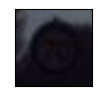

In [26]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_normal_dm.idx2label[lbl_np.item()])
gtsrb_normal_dm.unprocess_image(samp[0], plot=True)

In [27]:
ic(samp.shape)

ic| samp.shape: torch.Size([1, 3, 128, 128])


torch.Size([1, 3, 128, 128])

## GTSRB-Anomalies

In [28]:
dataset_path = "/media/farnez/Data/DATASETS/gtsrb-data/"

In [29]:
gtsrb_anomal_dm = GtsrbModule(img_size=(128, 128), data_path=dataset_path, batch_size=1, anomaly_transforms=True, shuffle=True)

In [30]:
gtsrb_anomal_dm.setup(stage='fit')
gtsrb_anomal_dm.setup(stage='validate')
gtsrb_anomal_dm.setup(stage='test')
# print(gtsrb_anomal_dm.ds_gtsrb_train)
# print(gtsrb_anomal_dm.ds_gtsrb_valid)
# print(gtsrb_anomal_dm.ds_gtsrb_test)

In [31]:
gtsrb_anomal_train_loader = gtsrb_anomal_dm.train_dataloader()
gtsrb_anomal_valid_loader = gtsrb_anomal_dm.val_dataloader()
gtsrb_anomal_test_loader = gtsrb_anomal_dm.test_dataloader()
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));

ic| len(gtsrb_anomal_train_loader): 35600


ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273


In [32]:
dataiter_anomal = iter(gtsrb_anomal_train_loader)

Traffic signals


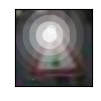

In [67]:
samp, lbl = dataiter_anomal.next()
lbl_np = lbl[0].cpu().numpy()
print(gtsrb_anomal_dm.idx2label[lbl_np.item()])
gtsrb_anomal_dm.unprocess_image(samp[0], plot=True)

In [90]:
gtsrb_anomal_dm.anomaly_transforms

True

In [91]:
samp.shape

torch.Size([1, 3, 128, 128])

## CIFAR-10 OoD

In [68]:
cifar10_data_dir = "/media/farnez/Data/DATASETS/cifar-10/"

In [69]:
cifar10_dm = CIFAR10DataModule(data_dir=cifar10_data_dir,
                               val_split=0.2,
                               num_workers=10,
                               normalize=True,
                               batch_size=1,
                               seed=10,
                               drop_last=True,
                               shuffle=True)

cifar10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=[0.3337, 0.3064, 0.3171],
        std=[0.2672, 0.2564, 0.2629]
    )
])

cifar10_dm.train_transforms = cifar10_transforms
cifar10_dm.test_transforms = cifar10_transforms
cifar10_dm.val_transforms  = cifar10_transforms

In [70]:
cifar10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [71]:
cifar10_dm.setup(stage='fit')
cifar10_dm.setup(stage='test')

In [72]:
cifar10_train_loader = cifar10_dm.train_dataloader()
cifar10_valid_loader = cifar10_dm.val_dataloader()
cifar10_test_loader = cifar10_dm.test_dataloader()
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));

ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000


In [73]:
def unprocess_cifar10_image(im,
                            norm_mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                            norm_std=[x / 255.0 for x in [63.0, 62.1, 66.7]], 
                            plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [74]:
dataiter = iter(cifar10_train_loader)

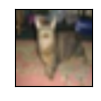

In [78]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_cifar10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

In [79]:
samp.shape

torch.Size([1, 3, 128, 128])

## STL-10 OoD

In [80]:
stl10_data_dir = "/media/farnez/Data/DATASETS/stl-10/"

In [81]:
stl10_dm = STL10DataModule(data_dir=stl10_data_dir,
                           train_val_split=3000,
                           num_workers=10,
                           batch_size=1,
                           seed=10,
                           drop_last=True,
                           shuffle=True)

stl10_transforms = transform_lib.Compose([
    transform_lib.Resize((128, 128)),
    transform_lib.ToTensor(),
    transform_lib.Normalize(
        mean=(0.3337, 0.3064, 0.3171),
        std=(0.2672, 0.2564, 0.2629)
    )
])

stl10_dm.train_transforms = stl10_transforms
stl10_dm.test_transforms = stl10_transforms
stl10_dm.val_transforms  = stl10_transforms

In [81]:
stl10_dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [82]:
stl10_train_loader = stl10_dm.train_dataloader_labeled()
stl10_valid_loader = stl10_dm.val_dataloader_labeled()
stl10_test_loader = stl10_dm.test_dataloader()
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


In [83]:
def unprocess_stl10_image(im,
                          norm_mean=[0.43, 0.42, 0.39],
                          norm_std=[0.27, 0.26, 0.27], 
                          plot=False):
    # im = im.squeeze().numpy().transpose((1, 2, 0))
    norm_mean = np.array(norm_mean)
    norm_std = np.array(norm_std)
    im = im.squeeze().numpy().transpose((1, 2, 0))
    im = norm_std * im + norm_mean
    im = np.clip(im, 0, 1)
    im = im * 255
    im = Image.fromarray(im.astype(np.uint8))

    if plot:
        plt.rcParams['figure.figsize'] = [2.54/2.54, 2.54/2.54]
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        return im

In [84]:
dataiter = iter(stl10_train_loader)

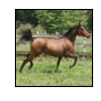

In [91]:
samp, lbl = dataiter.next()
lbl_np = lbl[0].cpu().numpy()
unprocess_stl10_image(samp[0], norm_mean=[0.3337, 0.3064, 0.3171], norm_std=[0.2672, 0.2564, 0.2629], plot=True)

In [92]:
samp.shape

torch.Size([1, 3, 128, 128])

# GTSRB ResNet18 Classifier

__Normal Classifier__

In [93]:
gtsrb_model_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-17_00-13-13/last.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_path)

In [94]:
gtsrb_model;

In [95]:
gtsrb_model.eval();

__Classifier with Spectral Normalization__

In [53]:
gtsrb_model_sn_path = "/home/farnez/Projects/GTSRB-Classifier/lightning_logs/2023-05-14_03-11-13/last.ckpt"
gtsrb_model = ResnetModule.load_from_checkpoint(checkpoint_path=gtsrb_model_sn_path)

In [57]:
gtsrb_model;

In [58]:
gtsrb_model.eval();

# Dataset Distribution Shift Detection Baselines

In [96]:
gtsrb_model;

In [97]:
ic(len(gtsrb_normal_train_loader));
ic(len(gtsrb_normal_valid_loader));
ic(len(gtsrb_normal_test_loader));
ic("========================================")
ic(len(gtsrb_anomal_train_loader));
ic(len(gtsrb_anomal_valid_loader));
ic(len(gtsrb_anomal_test_loader));
ic("========================================")
ic(len(cifar10_train_loader));
ic(len(cifar10_valid_loader));
ic(len(cifar10_test_loader));
ic("========================================")
ic(len(stl10_train_loader));
ic(len(stl10_valid_loader));
ic(len(stl10_test_loader));

ic| len(gtsrb_normal_train_loader): 7120
ic| len(gtsrb_normal_valid_loader): 3609
ic| len(gtsrb_normal_test_loader): 1273
ic| '========================================'
ic| len(gtsrb_anomal_train_loader): 35600
ic| len(gtsrb_anomal_valid_loader): 3609
ic| len(gtsrb_anomal_test_loader): 1273
ic| '========================================'
ic| len(cifar10_train_loader): 40000
ic| len(cifar10_valid_loader): 10000
ic| len(cifar10_test_loader): 10000
ic| '========================================'
ic| len(stl10_train_loader): 2000
ic| len(stl10_valid_loader): 3000
ic| len(stl10_test_loader): 8000


## Predictive Uncertainty

In [98]:
# Monte Carlo Dropout - Enable Dropout @ Test Time!
def resnet18_enable_dropblock2d_test(m):
    if type(m) == DropBlock2D:
        m.train()

In [99]:
gtsrb_model.to(device);
gtsrb_model.eval(); 
gtsrb_model.apply(resnet18_enable_dropblock2d_test); # enable dropout

In [182]:
def get_mcd_pred_uncertainty_score(dnn_model: torch.nn.Module,
                                   input_dataloader: DataLoader,
                                   mcd_nro_samples: int = 2):
    
    softmax_fn = torch.nn.Softmax(dim=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    gtsrb_model.to(device)
    with torch.no_grad():
        # dl_imgs_latent_mcd_samples = []
        # dl_pred_mcd_samples = []
        img_pred_mcd_samples = []
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            
            for sample in range(mcd_nro_samples):
                pred_img = dnn_model(image)      

                img_pred_mcd_samples.append(pred_img)

            img_pred_mcd_samples_t = torch.cat(img_pred_mcd_samples, dim=0)
            # ic(img_pred_mcd_samples_t.shape)
            
            # compute softmax output - normalized output:
            img_pred_softmax_mcd_samples_t = softmax_fn(img_pred_mcd_samples_t)
            
        dl_pred_mcd_samples = torch.split(img_pred_softmax_mcd_samples_t, mcd_nro_samples)
        # Get dataloader mcd predictions:
        dl_pred_mcd_samples_t = torch.stack(dl_pred_mcd_samples)
        
        # get predictive entropy:
        expect_preds = torch.mean(dl_pred_mcd_samples_t, dim=1)
        pred_h_t = -torch.sum((expect_preds * torch.log(expect_preds)), dim=1)
        # get expected entropy:
        preds_h = -torch.sum(dl_pred_mcd_samples_t * torch.log(dl_pred_mcd_samples_t), dim=-1)
        expected_h_preds_t = torch.mean(preds_h, dim=1)
        # get mutual information:
        mi_t = pred_h_t - expected_h_preds_t
       
    
    return dl_pred_mcd_samples_t, pred_h_t, mi_t


In [183]:
dl_gtsrb_test_preds, dl_gtsrb_test_pred_h, dl_gtsrb_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                         input_dataloader=gtsrb_normal_test_loader,
                                                                                         mcd_nro_samples=16)

In [184]:
dl_gtsrb_anomal_test_preds, dl_gtsrb_anomal_test_pred_h, dl_gtsrb_anomal_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                                              input_dataloader=gtsrb_anomal_test_loader,
                                                                                                              mcd_nro_samples=16)

In [185]:
dl_cifar10_test_preds, dl_cifar10_test_pred_h, dl_cifar10_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                         input_dataloader=cifar10_test_loader,
                                                                                         mcd_nro_samples=16)

In [186]:
dl_stl10_test_preds, dl_stl10_test_pred_h, dl_stl10_test_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                         input_dataloader=stl10_test_loader,
                                                                                         mcd_nro_samples=16)

In [254]:
dl_gtsrb_valid_preds, dl_gtsrb_valid_pred_h, dl_gtsrb_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                            input_dataloader=gtsrb_normal_valid_loader,
                                                                                            mcd_nro_samples=16)

In [255]:
dl_gtsrb_anomal_valid_preds, dl_gtsrb_anomal_valid_pred_h, dl_gtsrb_anomal_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                                                 input_dataloader=gtsrb_anomal_valid_loader,
                                                                                                                 mcd_nro_samples=16)

In [256]:
dl_cifar10_valid_preds, dl_cifar10_valid_pred_h, dl_cifar10_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                                  input_dataloader=cifar10_valid_loader,
                                                                                                  mcd_nro_samples=16)

In [257]:
dl_stl10_valid_preds, dl_stl10_valid_pred_h, dl_stl10_valid_mi = get_mcd_pred_uncertainty_score(dnn_model=gtsrb_model.model, 
                                                                                            input_dataloader=stl10_valid_loader,
                                                                                            mcd_nro_samples=16)

In [187]:
torch.save(dl_gtsrb_test_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_test_preds.pt')
torch.save(dl_gtsrb_test_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_test_pred_h.pt')
torch.save(dl_gtsrb_test_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_test_mi.pt')


torch.save(dl_gtsrb_anomal_test_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_test_preds.pt')
torch.save(dl_gtsrb_anomal_test_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_test_pred_h.pt')
torch.save(dl_gtsrb_anomal_test_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_test_mi.pt')


torch.save(dl_cifar10_test_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_test_preds.pt')
torch.save(dl_cifar10_test_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_test_pred_h.pt')
torch.save(dl_cifar10_test_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_test_mi.pt')


torch.save(dl_stl10_test_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_test_preds.pt')
torch.save(dl_stl10_test_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_test_pred_h.pt')
torch.save(dl_stl10_test_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_test_mi.pt')

In [258]:
torch.save(dl_gtsrb_valid_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_valid_preds.pt')
torch.save(dl_gtsrb_valid_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_valid_pred_h.pt')
torch.save(dl_gtsrb_valid_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_valid_mi.pt')


torch.save(dl_gtsrb_anomal_valid_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_valid_preds.pt')
torch.save(dl_gtsrb_anomal_valid_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_valid_pred_h.pt')
torch.save(dl_gtsrb_anomal_valid_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_gtsrb_anomal_valid_mi.pt')


torch.save(dl_cifar10_valid_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_valid_preds.pt')
torch.save(dl_cifar10_valid_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_valid_pred_h.pt')
torch.save(dl_cifar10_valid_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_cifar10_valid_mi.pt')


torch.save(dl_stl10_valid_preds,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_valid_preds.pt')
torch.save(dl_stl10_valid_pred_h,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_valid_pred_h.pt')
torch.save(dl_stl10_valid_mi,
           '/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/predicted_uncertainty/dl_stl10_valid_mi.pt')

In [216]:
ic(dl_gtsrb_test_pred_h.shape);
ic(dl_gtsrb_test_mi.shape);
ic("================================================================");
ic(dl_gtsrb_anomal_test_pred_h.shape);
ic(dl_gtsrb_anomal_test_mi.shape);
ic("================================================================");
ic(dl_cifar10_test_pred_h.shape);
ic(dl_cifar10_test_mi.shape);
ic("================================================================");
ic(dl_stl10_test_pred_h.shape);
ic(dl_stl10_test_mi.shape);

ic| dl_gtsrb_test_pred_h.shape: torch.Size([1273])


ic| dl_gtsrb_test_mi.shape: torch.Size([1273])
ic| '================================================================'
ic| dl_gtsrb_anomal_test_pred_h.shape: torch.Size([1273])
ic| dl_gtsrb_anomal_test_mi.shape: torch.Size([1273])
ic| '================================================================'
ic| dl_cifar10_test_pred_h.shape: torch.Size([10000])
ic| dl_cifar10_test_mi.shape: torch.Size([10000])
ic| '================================================================'
ic| dl_stl10_test_pred_h.shape: torch.Size([8000])
ic| dl_stl10_test_mi.shape: torch.Size([8000])


In [261]:
ind_gtsrb_test_pred_h_score = dl_gtsrb_test_pred_h.cpu().numpy()
ind_gtsrb_test_mi_score = dl_gtsrb_test_mi.cpu().numpy()
ic(ind_gtsrb_test_pred_h_score.shape);
ic(ind_gtsrb_test_mi_score.shape);

ood_gtsrb_anomal_test_pred_h_score = dl_gtsrb_anomal_test_pred_h.cpu().numpy()
ood_gtsrb_anomal_test_mi_score = dl_gtsrb_anomal_test_mi.cpu().numpy()
ic(ood_gtsrb_anomal_test_pred_h_score.shape);
ic(ood_gtsrb_anomal_test_mi_score.shape);

ood_cifar10_test_pred_h_score = dl_cifar10_test_pred_h.cpu().numpy()
ood_cifar10_test_mi_score = dl_cifar10_test_mi.cpu().numpy()
ic(ood_cifar10_test_pred_h_score.shape);
ic(ood_cifar10_test_mi_score.shape);

ood_stl10_test_pred_h_score = dl_stl10_test_pred_h.cpu().numpy()
ood_stl10_test_mi_score = dl_stl10_test_mi.cpu().numpy()
ic(ood_stl10_test_pred_h_score.shape);
ic(ood_stl10_test_mi_score.shape);

ic| ind_gtsrb_test_pred_h_score.shape: (1273,)
ic

| ind_gtsrb_test_mi_score.shape: (1273,)
ic| ood_gtsrb_anomal_test_pred_h_score.shape: (1273,)
ic| ood_gtsrb_anomal_test_mi_score.shape: (1273,)
ic| ood_cifar10_test_pred_h_score.shape: (10000,)
ic| ood_cifar10_test_mi_score.shape: (10000,)
ic| ood_stl10_test_pred_h_score.shape: (8000,)
ic| ood_stl10_test_mi_score.shape: (8000,)


In [262]:
ind_gtsrb_valid_pred_h_score = dl_gtsrb_valid_pred_h.cpu().numpy()
ind_gtsrb_valid_mi_score = dl_gtsrb_valid_mi.cpu().numpy()
ic(ind_gtsrb_valid_pred_h_score.shape);
ic(ind_gtsrb_valid_mi_score.shape);

ood_gtsrb_anomal_valid_pred_h_score = dl_gtsrb_anomal_valid_pred_h.cpu().numpy()
ood_gtsrb_anomal_valid_mi_score = dl_gtsrb_anomal_valid_mi.cpu().numpy()
ic(ood_gtsrb_anomal_valid_pred_h_score.shape);
ic(ood_gtsrb_anomal_valid_mi_score.shape);

ood_cifar10_valid_pred_h_score = dl_cifar10_valid_pred_h.cpu().numpy()
ood_cifar10_valid_mi_score = dl_cifar10_valid_mi.cpu().numpy()
ic(ood_cifar10_valid_pred_h_score.shape);
ic(ood_cifar10_valid_mi_score.shape);

ood_stl10_valid_pred_h_score = dl_stl10_valid_pred_h.cpu().numpy()
ood_stl10_valid_mi_score = dl_stl10_valid_mi.cpu().numpy()
ic(ood_stl10_valid_pred_h_score.shape);
ic(ood_stl10_valid_mi_score.shape);

ic| ind_gtsrb_valid_pred_h_score.shape: (3609,)
ic| ind_gtsrb_valid_mi_score.shape: (3609,)
ic| ood_gtsrb_anomal_valid_pred_h_score.shape: (3609,)
ic| ood_gtsrb_anomal_valid_mi_score.shape: (3609,)
ic| ood_cifar10_valid_pred_h_score.shape: (10000,)
ic| ood_cifar10_valid_mi_score.shape: (10000,)
ic| ood_stl10_valid_pred_h_score.shape: (3000,)
ic| ood_stl10_valid_mi_score.shape: (3000,)


In [263]:
ind_gtsrb_pred_h_score = np.concatenate((ind_gtsrb_valid_pred_h_score, ind_gtsrb_test_pred_h_score))
ind_gtsrb_pred_mi_score = np.concatenate((ind_gtsrb_valid_mi_score, ind_gtsrb_test_mi_score))

ood_gtsrb_anomal_pred_h_score = np.concatenate((ood_gtsrb_anomal_valid_pred_h_score, ood_gtsrb_anomal_test_pred_h_score))
ood_gtsrb_anomal_pred_mi_score = np.concatenate((ood_gtsrb_anomal_valid_mi_score, ood_gtsrb_anomal_test_mi_score))

ood_cifar10_pred_h_score = np.concatenate((ood_cifar10_valid_pred_h_score, ood_cifar10_test_pred_h_score))
ood_cifar10_pred_mi_score = np.concatenate((ood_cifar10_valid_mi_score, ood_cifar10_test_mi_score))

ood_stl10_pred_h_score = np.concatenate((ood_stl10_valid_pred_h_score, ood_stl10_test_pred_h_score))
ood_stl10_pred_mi_score = np.concatenate((ood_stl10_valid_mi_score, ood_stl10_test_mi_score))


### Plot Score Values Predictive Entropy

In [271]:
df_pred_h_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_stl10 = pd.DataFrame(ood_stl10_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_h_score, columns=["Predictive H score"])

df_pred_h_scores_gtsrb.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_h_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_h_scores_stl10.insert(0, "Dataset", "")
df_pred_h_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_h_scores_cifar10.insert(0, "Dataset", "")
df_pred_h_scores_cifar10.loc[:, "Dataset"] = "cifar10"

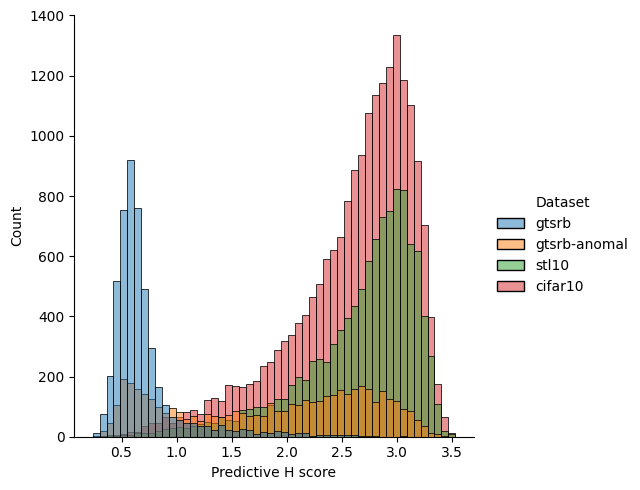

In [272]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal,
                              df_pred_h_scores_stl10,
                              df_pred_h_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

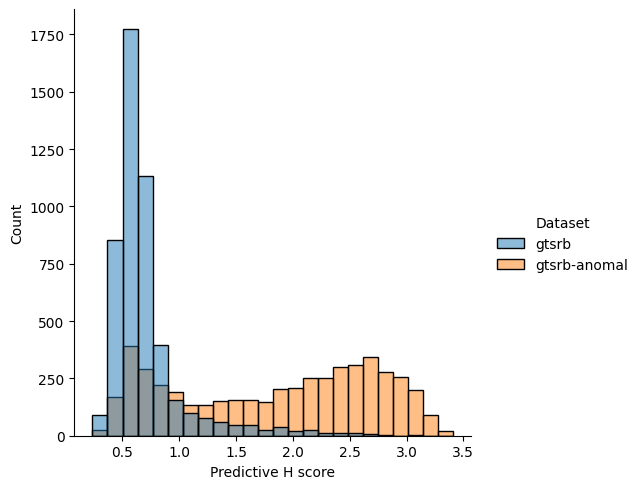

In [273]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score values Predictive MI

In [274]:
df_mi_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_stl10 = pd.DataFrame(ood_stl10_pred_mi_score, columns=["Predictive MI score"])
df_mi_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_mi_score, columns=["Predictive MI score"])

df_mi_scores_gtsrb.insert(0, "Dataset", "")
df_mi_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_mi_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_mi_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_mi_scores_stl10.insert(0, "Dataset", "")
df_mi_scores_stl10.loc[:, "Dataset"] = "stl10"

df_mi_scores_cifar10.insert(0, "Dataset", "")
df_mi_scores_cifar10.loc[:, "Dataset"] = "cifar10"

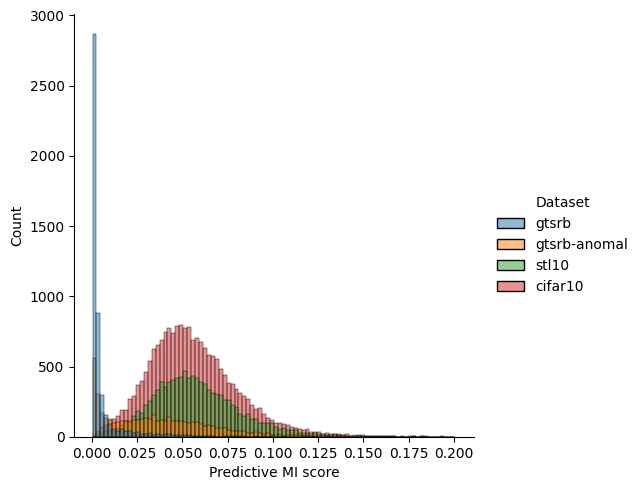

In [275]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal,
                               df_mi_scores_stl10,
                               df_mi_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

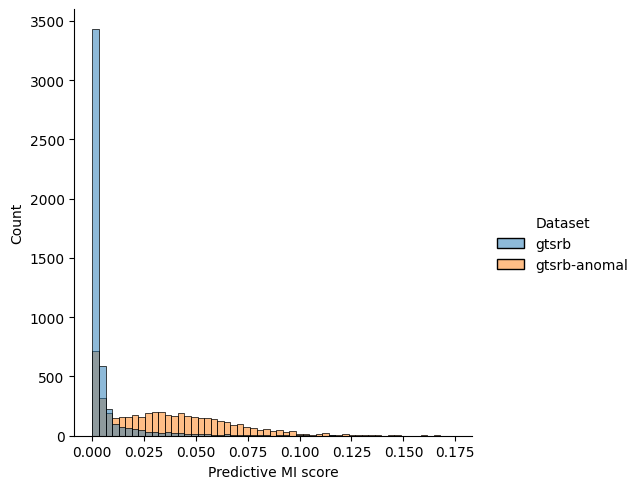

In [276]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score Values Predictive Entropy (test split)

In [235]:
df_pred_h_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_stl10 = pd.DataFrame(ood_stl10_test_pred_h_score, columns=["Predictive H score"])
df_pred_h_scores_cifar10 = pd.DataFrame(ood_cifar10_test_pred_h_score, columns=["Predictive H score"])

df_pred_h_scores_gtsrb.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_h_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_h_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_h_scores_stl10.insert(0, "Dataset", "")
df_pred_h_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_h_scores_cifar10.insert(0, "Dataset", "")
df_pred_h_scores_cifar10.loc[:, "Dataset"] = "cifar10"

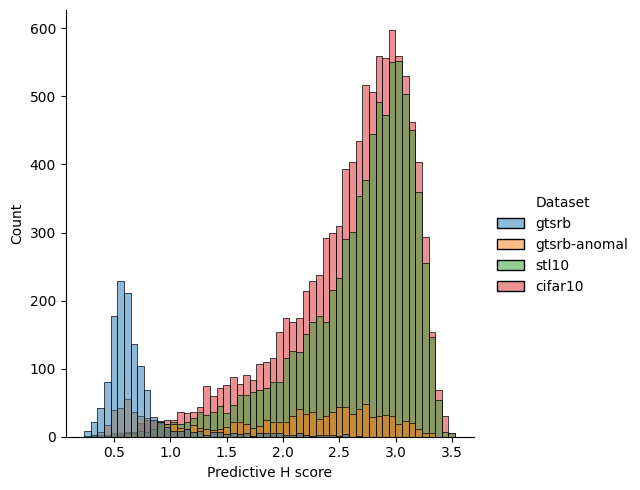

In [236]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal,
                              df_pred_h_scores_stl10,
                              df_pred_h_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

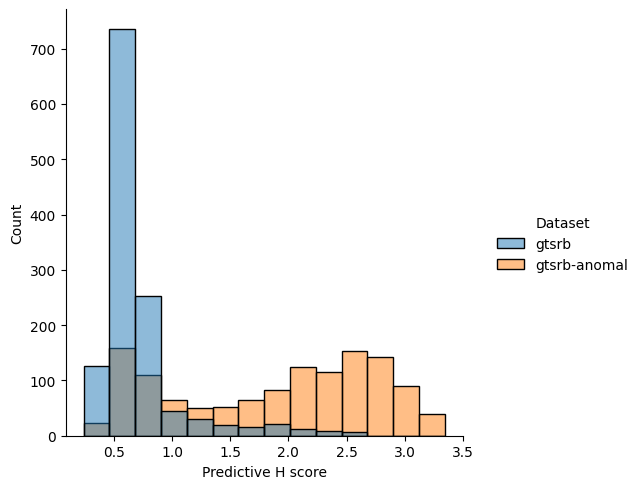

In [237]:
df_pred_h_scores = pd.concat([df_pred_h_scores_gtsrb,
                              df_pred_h_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive H score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Score values Predictive MI (test split)

In [232]:
df_mi_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_stl10 = pd.DataFrame(ood_stl10_test_mi_score, columns=["Predictive MI score"])
df_mi_scores_cifar10 = pd.DataFrame(ood_cifar10_test_mi_score, columns=["Predictive MI score"])

df_mi_scores_gtsrb.insert(0, "Dataset", "")
df_mi_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_mi_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_mi_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_mi_scores_stl10.insert(0, "Dataset", "")
df_mi_scores_stl10.loc[:, "Dataset"] = "stl10"

df_mi_scores_cifar10.insert(0, "Dataset", "")
df_mi_scores_cifar10.loc[:, "Dataset"] = "cifar10"

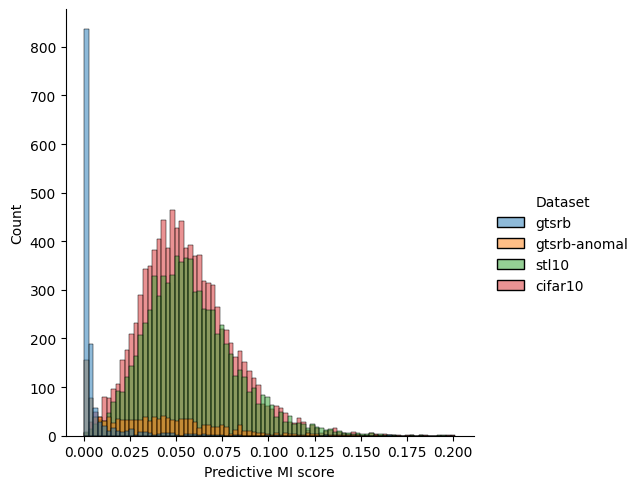

In [233]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal,
                               df_mi_scores_stl10,
                               df_mi_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

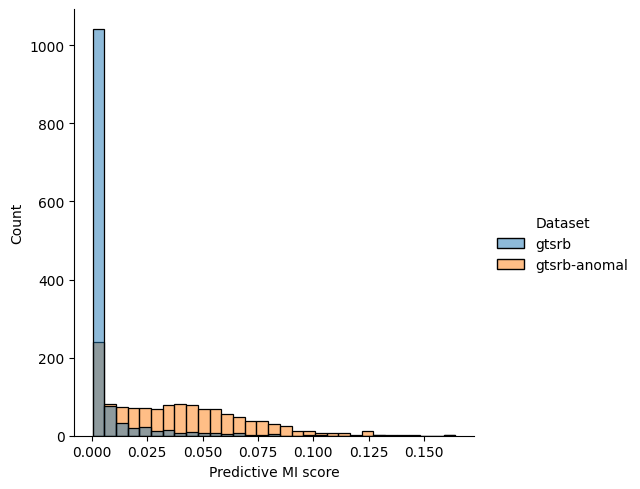

In [234]:
df_pred_mi_scores = pd.concat([df_mi_scores_gtsrb,
                               df_mi_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_mi_scores, x="Predictive MI score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [277]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_h_score.shape);

results_pred_h_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. gtsrb_anomaly",
                                                     ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                     ood_samples_scores=-ood_gtsrb_anomal_pred_h_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8675
FPR95: 0.3515
AUPR: 0.8036


In [280]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_mi_score.shape);

results_pred_mi_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. gtsrb_anomaly",
                                                             ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                             ood_samples_scores=-ood_gtsrb_anomal_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8607
FPR95: 0.4795
AUPR: 0.8224


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [281]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_cifar10_pred_h_score.shape);

results_pred_h_cifar10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. cifar10",
                                                      ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                      ood_samples_scores=-ood_cifar10_pred_h_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9890
FPR95: 0.0476
AUPR: 0.9617


In [282]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_cifar10_pred_mi_score.shape);

results_pred_mi_cifar10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. cifar10",
                                                       ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                       ood_samples_scores=-ood_cifar10_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9725
FPR95: 0.1406
AUPR: 0.9499


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [283]:
print("Test InD shape", ind_gtsrb_pred_h_score.shape);
print("Test OoD shape", ood_stl10_pred_h_score.shape);

results_pred_h_stl10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. stl10",
                                                      ind_samples_scores=-ind_gtsrb_pred_h_score,
                                                      ood_samples_scores=-ood_stl10_pred_h_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9905
FPR95: 0.0388
AUPR: 0.9772


In [284]:
print("Test InD shape", ind_gtsrb_pred_mi_score.shape);
print("Test OoD shape", ood_stl10_pred_mi_score.shape);

results_pred_mi_stl10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. stl10",
                                                       ind_samples_scores=-ind_gtsrb_pred_mi_score,
                                                       ood_samples_scores=-ood_stl10_pred_mi_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9750
FPR95: 0.1176
AUPR: 0.9679


### GTSRB vs GTSRB-Anomalies (test split)

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [247]:
print("Test InD shape", ind_gtsrb_test_pred_h_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_test_pred_h_score.shape);

results_pred_h_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. gtsrb_anomaly",
                                                     ind_samples_scores=-ind_gtsrb_test_pred_h_score,
                                                     ood_samples_scores=-ood_gtsrb_anomal_test_pred_h_score)

Test InD shape (1273,)
Test OoD shape (1273,)
AUROC: 0.8728
FPR95: 0.3645
AUPR: 0.8211


In [249]:
print("Test InD shape", ind_gtsrb_test_mi_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_test_mi_score.shape);

results_pred_mi_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. gtsrb_anomaly",
                                                             ind_samples_scores=-ind_gtsrb_test_mi_score,
                                                             ood_samples_scores=-ood_gtsrb_anomal_test_mi_score)

Test InD shape (1273,)
Test OoD shape (1273,)
AUROC: 0.8652
FPR95: 0.4815
AUPR: 0.8309


### GTSRB vs CIFAR-10 (test split)

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [250]:
print("Test InD shape", ind_gtsrb_test_pred_h_score.shape);
print("Test OoD shape", ood_cifar10_test_pred_h_score.shape);

results_pred_h_cifar10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. cifar10",
                                                      ind_samples_scores=-ind_gtsrb_test_pred_h_score,
                                                      ood_samples_scores=-ood_cifar10_test_pred_h_score)

Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.9882
FPR95: 0.0675
AUPR: 0.9383


In [251]:
print("Test InD shape", ind_gtsrb_test_mi_score.shape);
print("Test OoD shape", ood_cifar10_test_mi_score.shape);

results_pred_mi_cifar10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. cifar10",
                                                       ind_samples_scores=-ind_gtsrb_test_mi_score,
                                                       ood_samples_scores=-ood_cifar10_test_mi_score)

Test InD shape (1273,)
Test OoD shape (10000,)
AUROC: 0.9701
FPR95: 0.1651
AUPR: 0.9307


### GTSRB vs STL-10 (test split)

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [252]:
print("Test InD shape", ind_gtsrb_test_pred_h_score.shape);
print("Test OoD shape", ood_stl10_test_pred_h_score.shape);

results_pred_h_stl10_test = get_hz_detector_results(detect_exp_name="predictive h: gtsrb vs. stl10",
                                                      ind_samples_scores=-ind_gtsrb_test_pred_h_score,
                                                      ood_samples_scores=-ood_stl10_test_pred_h_score)

Test InD shape (1273,)
Test OoD shape (8000,)
AUROC: 0.9899
FPR95: 0.0510
AUPR: 0.9458


In [253]:
print("Test InD shape", ind_gtsrb_test_mi_score.shape);
print("Test OoD shape", ood_stl10_test_mi_score.shape);

results_pred_mi_stl10_test = get_hz_detector_results(detect_exp_name="predictive mi: gtsrb vs. stl10",
                                                       ind_samples_scores=-ind_gtsrb_test_mi_score,
                                                       ood_samples_scores=-ood_stl10_test_mi_score)

Test InD shape (1273,)
Test OoD shape (8000,)
AUROC: 0.9724
FPR95: 0.1395
AUPR: 0.9404


## MSP Score

In [311]:
gtsrb_model.to(device);
gtsrb_model.eval(); 

In [315]:
def get_msp_score(dnn_model: torch.nn.Module,
                  input_dataloader: DataLoader):
    
    softmax_fn = torch.nn.Softmax(dim=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gtsrb_model.to(device)
    dl_preds = []
    dl_preds_msp_scores = []

    with torch.no_grad():
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
                                    
            pred_score = torch.max(softmax_fn(pred_logits), dim=1)
            # ic(pred_score.shape)
            # get the max values:
            dl_preds_msp_scores.append(pred_score[0])
        
        dl_preds_msp_scores_t = torch.cat(dl_preds_msp_scores, dim=0)
        # ic(dl_preds_msp_scores_t.shape)
        # pred = np.max(softmax_fn(pred_logits).detach().cpu().numpy(), axis=1)
        dl_preds_msp_scores = dl_preds_msp_scores_t.detach().cpu().numpy()
        
    return dl_preds_msp_scores

In [325]:
ind_gtsrb_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_normal_test_loader)
ood_gtsrb_anomal_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_anomal_test_loader)
ood_cifar10_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=cifar10_test_loader)
ood_stl10_test_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=stl10_test_loader)

In [343]:
ind_gtsrb_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_normal_valid_loader)
ood_gtsrb_anomal_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_anomal_valid_loader)
ood_cifar10_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=cifar10_valid_loader)
ood_stl10_valid_pred_msp_score = get_msp_score(dnn_model=gtsrb_model.model, input_dataloader=stl10_valid_loader)

In [344]:
ind_gtsrb_pred_msp_score = np.concatenate((ind_gtsrb_valid_pred_msp_score, ind_gtsrb_test_pred_msp_score))
ood_gtsrb_anomal_pred_msp_score = np.concatenate((ood_gtsrb_anomal_valid_pred_msp_score, ood_gtsrb_anomal_test_pred_msp_score))
ood_cifar10_pred_msp_score = np.concatenate((ood_cifar10_valid_pred_msp_score, ood_cifar10_test_pred_msp_score))
ood_stl10_pred_msp_score = np.concatenate((ood_stl10_valid_pred_msp_score, ood_stl10_test_pred_msp_score))

In [345]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/msp_score/ind_gtsrb_pred_msp_score',
        ind_gtsrb_pred_msp_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/msp_score/ood_gtsrb_anomal_pred_msp_score',
        ood_gtsrb_anomal_pred_msp_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/msp_score/ood_cifar10_pred_msp_score',
        ood_cifar10_pred_msp_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/msp_score/ood_stl10_pred_msp_score',
        ood_stl10_pred_msp_score)

### Plot MSP scores

In [346]:
df_pred_msp_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_stl10 = pd.DataFrame(ood_stl10_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_msp_score, columns=["Predictive MSP score"])

df_pred_msp_scores_gtsrb.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_msp_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_msp_scores_stl10.insert(0, "Dataset", "")
df_pred_msp_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_msp_scores_cifar10.insert(0, "Dataset", "")
df_pred_msp_scores_cifar10.loc[:, "Dataset"] = "cifar10"

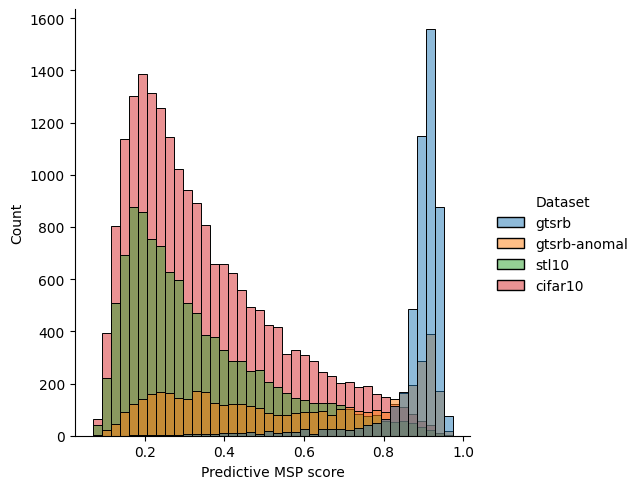

In [347]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                              df_pred_msp_scores_gtsrb_anomal,
                              df_pred_msp_scores_stl10,
                              df_pred_msp_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

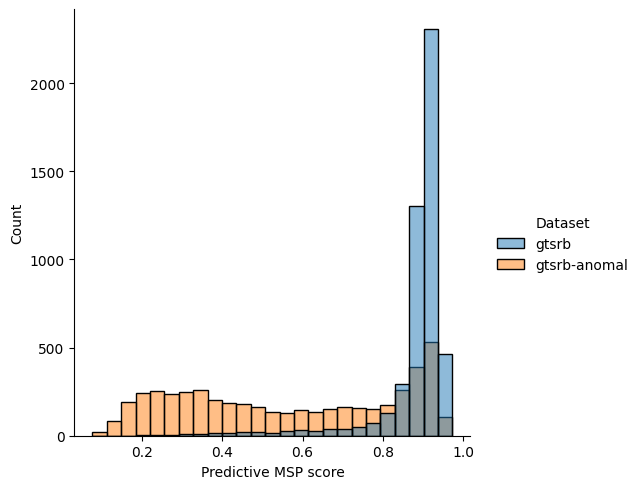

In [348]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                              df_pred_msp_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot MSP scores (test-split)

In [329]:
df_pred_msp_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_stl10 = pd.DataFrame(ood_stl10_test_pred_msp_score, columns=["Predictive MSP score"])
df_pred_msp_scores_cifar10 = pd.DataFrame(ood_cifar10_test_pred_msp_score, columns=["Predictive MSP score"])

df_pred_msp_scores_gtsrb.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_msp_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_msp_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_msp_scores_stl10.insert(0, "Dataset", "")
df_pred_msp_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_msp_scores_cifar10.insert(0, "Dataset", "")
df_pred_msp_scores_cifar10.loc[:, "Dataset"] = "cifar10"

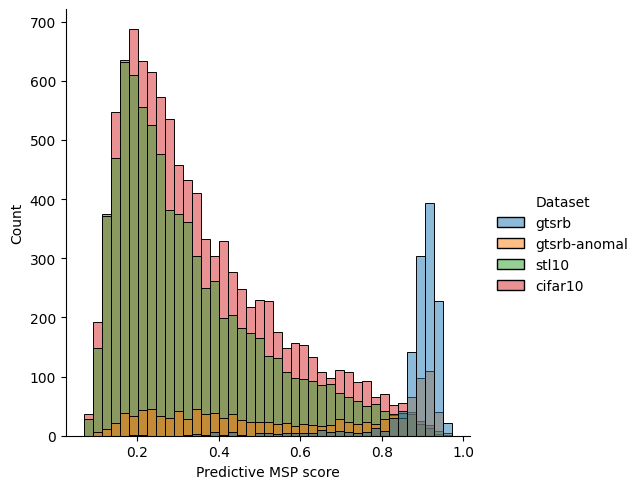

In [331]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                              df_pred_msp_scores_gtsrb_anomal,
                              df_pred_msp_scores_stl10,
                              df_pred_msp_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

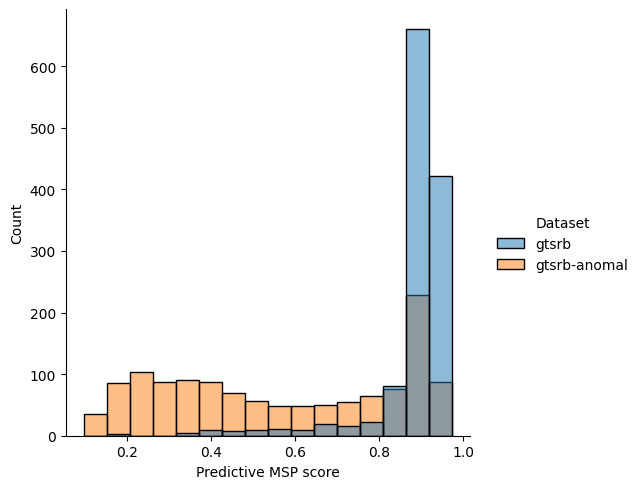

In [332]:
df_pred_h_scores = pd.concat([df_pred_msp_scores_gtsrb,
                              df_pred_msp_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive MSP score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [354]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_msp_score.shape);

results_pred_msp_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. gtsrb_anomaly",
                                                              ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                              ood_samples_scores=ood_gtsrb_anomal_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8624
FPR95: 0.3869
AUPR: 0.8023


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [355]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_cifar10_pred_msp_score.shape);

results_pred_msp_cifar10_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. cifar10",
                                                        ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                        ood_samples_scores=ood_cifar10_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9848
FPR95: 0.0691
AUPR: 0.9522


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [357]:
print("Test InD shape", ind_gtsrb_pred_msp_score.shape);
print("Test OoD shape", ood_stl10_pred_msp_score.shape);

results_pred_msp_stl10_test = get_hz_detector_results(detect_exp_name="MSP score: gtsrb vs. stl10",
                                                      ind_samples_scores=ind_gtsrb_pred_msp_score,
                                                      ood_samples_scores=ood_stl10_pred_msp_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9858
FPR95: 0.0594
AUPR: 0.9685


## Energy Score

In [ ]:
gtsrb_model.to(device);
gtsrb_model.eval(); 

In [333]:
def get_energy_score(dnn_model: torch.nn.Module,
                     input_dataloader: DataLoader):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    gtsrb_model.to(device)

    dl_preds_energy_scores = []

    with torch.no_grad():
        
        for i, (image, label) in enumerate(input_dataloader):
            image = image.to(device)
            pred_logits = dnn_model(image)
            
            pred_energy_score = torch.logsumexp(pred_logits, dim=1)

            dl_preds_energy_scores.append(pred_energy_score)
        
        dl_preds_energy_scores_t = torch.cat(dl_preds_energy_scores, dim=0)
     
        dl_preds_energy_scores = dl_preds_energy_scores_t.detach().cpu().numpy()
        
    return dl_preds_energy_scores

In [334]:
ind_gtsrb_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_normal_test_loader)
ood_gtsrb_anomal_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_anomal_test_loader)
ood_cifar10_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=cifar10_test_loader)
ood_stl10_test_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=stl10_test_loader)

In [340]:
ind_gtsrb_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_normal_valid_loader)
ood_gtsrb_anomal_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=gtsrb_anomal_valid_loader)
ood_cifar10_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=cifar10_valid_loader)
ood_stl10_valid_pred_energy_score = get_energy_score(dnn_model=gtsrb_model.model, input_dataloader=stl10_valid_loader)

In [341]:
ind_gtsrb_pred_energy_score = np.concatenate((ind_gtsrb_valid_pred_energy_score, ind_gtsrb_test_pred_energy_score))
ood_gtsrb_anomal_pred_energy_score = np.concatenate((ood_gtsrb_anomal_valid_pred_energy_score, ood_gtsrb_anomal_test_pred_energy_score))
ood_cifar10_pred_energy_score = np.concatenate((ood_cifar10_valid_pred_energy_score, ood_cifar10_test_pred_energy_score))
ood_stl10_pred_energy_score = np.concatenate((ood_stl10_valid_pred_energy_score, ood_stl10_test_pred_energy_score))

In [342]:
np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/energy_score/ind_gtsrb_pred_energy_score',
        ind_gtsrb_pred_energy_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/energy_score/ood_gtsrb_anomal_pred_energy_score',
        ood_gtsrb_anomal_pred_energy_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/energy_score/ood_cifar10_pred_energy_score',
        ood_cifar10_pred_energy_score)

np.save('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/OoD_detection_baselines/energy_score/ood_stl10_pred_energy_score',
        ood_stl10_pred_energy_score)

### Plot Energy scores

In [349]:
df_pred_energy_scores_gtsrb = pd.DataFrame(ind_gtsrb_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_stl10 = pd.DataFrame(ood_stl10_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_cifar10 = pd.DataFrame(ood_cifar10_pred_energy_score, columns=["Predictive Energy score"])

df_pred_energy_scores_gtsrb.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_energy_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_energy_scores_stl10.insert(0, "Dataset", "")
df_pred_energy_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_energy_scores_cifar10.insert(0, "Dataset", "")
df_pred_energy_scores_cifar10.loc[:, "Dataset"] = "cifar10"

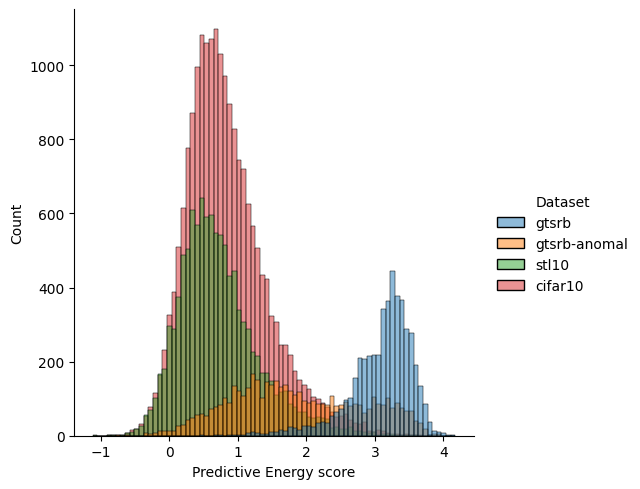

In [350]:
df_pred_h_scores = pd.concat([df_pred_energy_scores_gtsrb,
                              df_pred_energy_scores_gtsrb_anomal,
                              df_pred_energy_scores_stl10,
                              df_pred_energy_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive Energy score", hue="Dataset", kind="hist", fill=True)
plt.show()

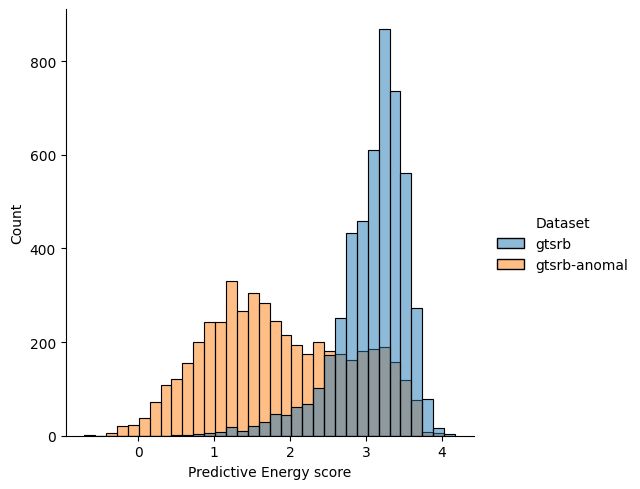

In [351]:
df_pred_h_scores = pd.concat([df_pred_energy_scores_gtsrb,
                              df_pred_energy_scores_gtsrb_anomal]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive Energy score", hue="Dataset", kind="hist", fill=True)
plt.show()

### Plot Energy scores (test-split)

In [338]:
df_pred_energy_scores_gtsrb = pd.DataFrame(ind_gtsrb_test_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_gtsrb_anomal = pd.DataFrame(ood_gtsrb_anomal_test_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_stl10 = pd.DataFrame(ood_stl10_test_pred_energy_score, columns=["Predictive Energy score"])
df_pred_energy_scores_cifar10 = pd.DataFrame(ood_cifar10_test_pred_energy_score, columns=["Predictive Energy score"])

df_pred_energy_scores_gtsrb.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_pred_energy_scores_gtsrb_anomal.insert(0, "Dataset", "")
df_pred_energy_scores_gtsrb_anomal.loc[:, "Dataset"] = "gtsrb-anomal"

df_pred_energy_scores_stl10.insert(0, "Dataset", "")
df_pred_energy_scores_stl10.loc[:, "Dataset"] = "stl10"

df_pred_energy_scores_cifar10.insert(0, "Dataset", "")
df_pred_energy_scores_cifar10.loc[:, "Dataset"] = "cifar10"

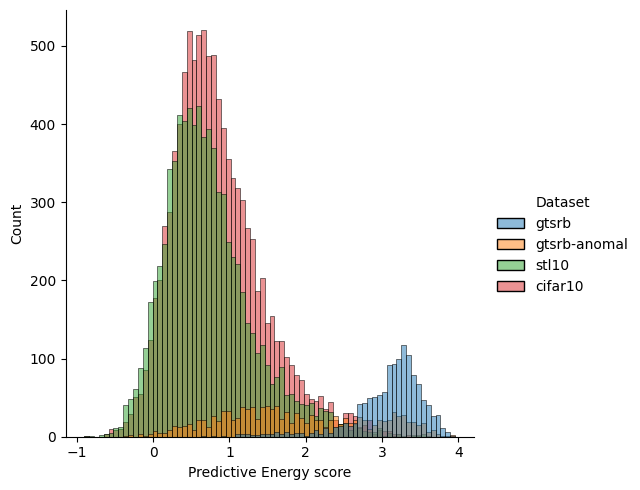

In [339]:
df_pred_h_scores = pd.concat([df_pred_energy_scores_gtsrb,
                              df_pred_energy_scores_gtsrb_anomal,
                              df_pred_energy_scores_stl10,
                              df_pred_energy_scores_cifar10]).reset_index(drop=True)

sns.displot(df_pred_h_scores, x="Predictive Energy score", hue="Dataset", kind="hist", fill=True)
plt.show()

### GTSRB vs GTSRB-Anomalies

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [358]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_gtsrb_anomal_pred_energy_score.shape);

results_pred_energy_gtsrb_anomaly_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. gtsrb_anomaly",
                                                              ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                              ood_samples_scores=ood_gtsrb_anomal_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (4882,)
AUROC: 0.8599
FPR95: 0.3726
AUPR: 0.8012


### GTSRB vs CIFAR-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [360]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_cifar10_pred_energy_score.shape);

results_pred_energy_cifar10_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. cifar10",
                                                           ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                           ood_samples_scores=ood_cifar10_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9915
FPR95: 0.0349
AUPR: 0.9682


### GTSRB vs STL-10

We use negative uncertainty scores for to align with the convention that positive (in-distribution) samples have higher scores (see plots above)

In [361]:
print("Test InD shape", ind_gtsrb_pred_energy_score.shape);
print("Test OoD shape", ood_stl10_pred_energy_score.shape);

results_pred_energy_stl10_test = get_hz_detector_results(detect_exp_name="Energy score: gtsrb vs. stl10",
                                                         ind_samples_scores=ind_gtsrb_pred_energy_score,
                                                         ood_samples_scores=ood_stl10_pred_energy_score)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9928
FPR95: 0.0293
AUPR: 0.9831


# Help Computations

In [150]:
a = torch.mean(dl_preds, dim=1)
ic(a.shape);
h = - torch.sum(a * torch.log(a), dim=1)
ic(h.shape);

ic| a.shape: torch.Size([1273, 43])
ic| h.shape: torch.Size([1273])


In [145]:
dl_preds.shape

torch.Size([1273, 4, 43])

In [170]:
b = -torch.sum(dl_preds * torch.log(dl_preds), dim=-1)
b.shape

torch.Size([1273, 4])

In [171]:
c = torch.mean(b, dim=-1)
c.shape

torch.Size([1273])

In [172]:
c

tensor([1.6442, 1.0367, 0.8926,  ..., 0.4374, 0.6017, 1.2400], device='cuda:0')

In [173]:
h

tensor([1.7476, 1.0509, 0.8985,  ..., 0.4385, 0.6024, 1.2487], device='cuda:0')